In [1397]:
import pandas as pd
import numpy as np
# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import cv2
import numpy.matlib as ml
import tqdm as t
import skimage.transform as skt
import torchvision.models as models

## **Image Loading and Preparation**

In [1588]:
train_img = [];
train_y = [];

In [1589]:
# Training Image Loader and Feature Extraction
for _classname in t.tqdm(range(1,7)):
    for _id in range(1,21):
        path = 'Char_Tr/Tr/' + str(_classname) + '/text (' + str(_id) + ').bmp';
        img = imread(path, as_gray=True)
        # converting the type of pixel to float
        img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
        img = np.invert(img)
        img = img.astype('float32')
        img /= 255.0
        # appending the image into the list
        train_img.append(img)
        train_y.append(_classname)
# tmpShape = np.array(datatrain).shape;
# datatrain = np.reshape(np.array(datatrain),(-1,tmpShape[1])).T

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 79.97it/s]


In [1590]:
train_x = np.array(train_img)
train_y = np.array(train_y)
# defining the target
print(train_x.shape)

(120, 128, 128)


In [1591]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2, random_state = 15)

In [1592]:
val_y

array([6, 2, 1, 6, 1, 3, 5, 2, 5, 5, 3, 4, 4, 6, 5, 3, 2, 2, 4, 6, 5, 2,
       1, 2])

In [1593]:
# pd.DataFrame(val_y).count

In [1594]:
train_x.shape

(96, 128, 128)

In [1595]:
val_x.shape

(24, 128, 128)

In [1596]:
# converting training images into torch format
train_x = train_x.reshape(96, 1, 128, 128)
train_x = torch.from_numpy(train_x).to(torch.float32)
# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y).to(torch.float32)
# shape of training data
print(train_x.shape, train_y.shape)
# converting validation images into torch format
val_x = val_x.reshape(24, 1, 128, 128)
val_x = torch.from_numpy(val_x).to(torch.float32)
# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y).to(torch.float32)
# shape of validation data
print(val_x.shape, val_y.shape)

torch.Size([96, 1, 128, 128]) torch.Size([96])
torch.Size([24, 1, 128, 128]) torch.Size([24])


## **CNN Constructor**

In [1597]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            Conv2d(1, 12, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(12),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            Conv2d(12, 24, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(24),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=1, stride=2)
        )
        self.drop_out = Dropout()
        self.fc1 = Linear(24576, 7)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0),-1)
        out = self.drop_out(out)
        out = self.fc1(out)
        return out

In [1598]:
# defining the model
model = Net()

In [1599]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
# defining the loss function
criterion = CrossEntropyLoss()
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=24576, out_features=7, bias=True)
)


In [1930]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

In [1931]:
# defining the number of epochs
n_epochs = 10
# training the model
for epoch in tqdm(range(n_epochs)):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]


In [1932]:
# computing the training and validation loss
# convert the results because they aren't in the good format
y_train = y_train.long() 
y_train = y_train.squeeze_()
y_val = y_val.long() 
y_val = y_val.squeeze_()
loss_train = criterion(output_train, y_train)
loss_val = criterion(output_val, y_val)
train_losses.append(loss_train)
val_losses.append(loss_val)
# computing the updated weights of all the model parameters
loss_train.backward()
optimizer.step()
tr_loss = loss_train.item()

In [1933]:
train_losses

[tensor(4.2067e-05, grad_fn=<NllLossBackward>)]

In [1934]:
torch.save(model, 'TortureNet.pt')

## **Testing**

In [1935]:
train_model = torch.load('TortureNet.pt')

In [1937]:
with torch.no_grad():
    output = train_model(val_x)
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)
# accuracy on validation set
accuracy_score(val_y, predictions)

0.9583333333333334

In [1938]:
val_y

tensor([6., 2., 1., 6., 1., 3., 5., 2., 5., 5., 3., 4., 4., 6., 5., 3., 2., 2.,
        4., 6., 5., 2., 1., 2.])

In [1939]:
predictions

array([6, 2, 1, 6, 1, 3, 5, 2, 5, 4, 3, 4, 4, 6, 5, 3, 2, 2, 4, 6, 5, 2,
       1, 2], dtype=int64)

## **Predict Section**

In [1940]:
# Change path of prediction here
path = 'Char_Tr/Tr/6/text (11).bmp';
img = imread(path, as_gray=True)
# converting the type of pixel to float
img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
img = np.invert(img)
img = img.astype('float32')
img /= 255.0
img = np.array(img)
img = img.reshape(1, 1, 128, 128)
img = torch.from_numpy(img).to(torch.float32)

with torch.no_grad():
    predict_result = train_model(img)
softmax_one = torch.exp(predict_result).cpu()
prob_pre = list(softmax_one.numpy())
predictions_result = np.argmax(prob_pre, axis=1)
print('The image is predicted as class ' + str(predictions_result))

The image is predicted as class [6]


## **Evaluation**

In [1941]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

In [1942]:
predictions

array([6, 2, 1, 6, 1, 3, 5, 2, 5, 4, 3, 4, 4, 6, 5, 3, 2, 2, 4, 6, 5, 2,
       1, 2], dtype=int64)

In [1943]:
val_y

tensor([6., 2., 1., 6., 1., 3., 5., 2., 5., 5., 3., 4., 4., 6., 5., 3., 2., 2.,
        4., 6., 5., 2., 1., 2.])

In [1944]:
print(classification_report(val_y, predictions))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       1.00      1.00      1.00         6
         3.0       1.00      1.00      1.00         3
         4.0       0.75      1.00      0.86         3
         5.0       1.00      0.80      0.89         5
         6.0       1.00      1.00      1.00         4

    accuracy                           0.96        24
   macro avg       0.96      0.97      0.96        24
weighted avg       0.97      0.96      0.96        24



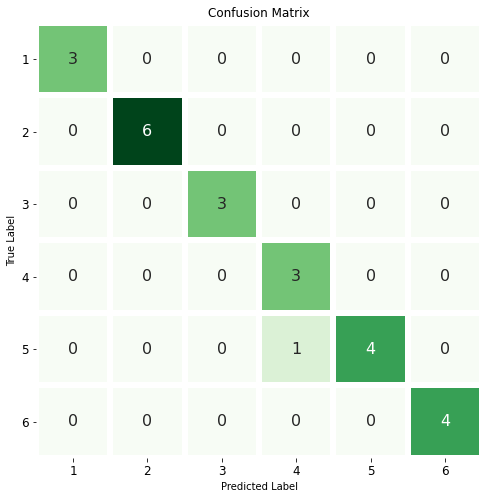

In [1945]:
cm = confusion_matrix(val_y, predictions)
df1 = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6], index= [1, 2, 3, 4, 5, 6], data= cm)
f,ax = plt.subplots(figsize=(8,8))


sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()